In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme(palette=sns.color_palette('Set2'))
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 150

## data import

In [3]:
# frame = pd.read_csv('..//1_web_scraping//apartment_details.csv')

In [48]:
query = '''
    select * from apt_details_raw
    where date = (select max(date) from apt_details_raw)
    '''

username = 'piotr'
password = os.environ['MYSQL_PASSWORD']
host = 'localhost'
db_name = 'airflow_db'
db_url = f'mysql+mysqlconnector://{username}:{password}@{host}/{db_name}'

engine = create_engine(db_url)

with engine.connect() as conn:
    frame = pd.read_sql_query(sql=query, con=conn, index_col='id')

frame.drop(['date'], axis=1, inplace=True)

for column in ['localization_y','localization_x','area','build_yr']:
    frame[column] = frame[column].astype('float')

In [49]:
frame.head()

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
id,,,,,,,,,,,,,,
0,Zakopane,tatrzański,małopolskie,49.299181,19.949562,pierwotny,sprzedaz,13.00,1,1,2,NaN,299999,https://gratka.pl/nieruchomosci/nowe-mieszkanie-zakopane-ul-krzeptowki/ob/33222047
0,Wrocław,Stare Miasto,dolnośląskie,51.111980,17.031187,wtorny,sprzedaz,19.00,1,parter,4,1930.0,375000,https://gratka.pl/nieruchomosci/mieszkanie-wroclaw-stare-miasto-ul-odrzanska/ob/33007209
0,Kraków,Stare Miasto,małopolskie,50.073995,19.946945,wtorny,sprzedaz,16.03,1,3,4,2023.0,356667,https://gratka.pl/nieruchomosci/mieszkanie-krakow-stare-miasto-ul-zelazna/ob/31022665
0,Warszawa,Mokotów,mazowieckie,52.195588,21.023771,wtorny,sprzedaz,19.00,1,2,6,1958.0,521000,https://gratka.pl/nieruchomosci/mieszkanie-warszawa-mokotow-ul-pulawska/ob/33301239
0,Warszawa,Śródmieście,mazowieckie,52.229676,21.012229,wtorny,sprzedaz,20.00,1,9,None,1966.0,600000,https://gratka.pl/nieruchomosci/mieszkanie-warszawa-srodmiescie/ob/33233857


In [50]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439 entries, 0 to 0
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            439 non-null    object 
 1   district        387 non-null    object 
 2   voivodeship     439 non-null    object 
 3   localization_y  414 non-null    float64
 4   localization_x  414 non-null    float64
 5   market          364 non-null    object 
 6   offer_type      364 non-null    object 
 7   area            402 non-null    float64
 8   rooms           438 non-null    object 
 9   floor           399 non-null    object 
 10  floors          383 non-null    object 
 11  build_yr        201 non-null    float64
 12  price           439 non-null    object 
 13  url             439 non-null    object 
dtypes: float64(4), object(10)
memory usage: 51.4+ KB


In [51]:
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
localization_y,414.0,51.654885,1.400859,49.281157,50.082281,52.171892,52.238328,54.554022
localization_x,414.0,19.616459,1.584382,14.241210,18.646600,19.947715,20.849221,23.791770
area,402.0,17.545274,1.934595,10.000000,16.200000,17.670000,19.000000,20.000000
build_yr,201.0,1986.945274,40.288733,1896.000000,1958.000000,2010.000000,2023.000000,2025.000000


In [52]:
len(frame) == len(frame.drop_duplicates())

True

In [53]:
frame.offer_type.value_counts(normalize=True)

offer_type
sprzedaz    1.0
Name: proportion, dtype: float64

## renaming market type

In [54]:
frame.market.replace(['pierwotny','wtorny'], ['primary_market','aftermarket'], inplace=True)

## removing foreign locations

In [55]:
len(frame[frame.voivodeship=='zagranica'])/len(frame)

0.0

In [56]:
frame.drop(frame[frame.voivodeship=='zagranica'].index, inplace=True)

## removing data with no price

In [57]:
frame.price.value_counts(normalize=True).loc['Zapytajoce']

0.1867881548974943

In [58]:
frame

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
id,,,,,,,,,,,,,,
0,Zakopane,tatrzański,małopolskie,49.299181,19.949562,primary_market,sprzedaz,13.00,1,1,2,NaN,299999,https://gratka.pl/nieruchomosci/nowe-mieszkanie-zakopane-ul-krzeptowki/ob/33222047
0,Wrocław,Stare Miasto,dolnośląskie,51.111980,17.031187,aftermarket,sprzedaz,19.00,1,parter,4,1930.0,375000,https://gratka.pl/nieruchomosci/mieszkanie-wroclaw-stare-miasto-ul-odrzanska/ob/33007209
0,Kraków,Stare Miasto,małopolskie,50.073995,19.946945,aftermarket,sprzedaz,16.03,1,3,4,2023.0,356667,https://gratka.pl/nieruchomosci/mieszkanie-krakow-stare-miasto-ul-zelazna/ob/31022665
0,Warszawa,Mokotów,mazowieckie,52.195588,21.023771,aftermarket,sprzedaz,19.00,1,2,6,1958.0,521000,https://gratka.pl/nieruchomosci/mieszkanie-warszawa-mokotow-ul-pulawska/ob/33301239
0,Warszawa,Śródmieście,mazowieckie,52.229676,21.012229,aftermarket,sprzedaz,20.00,1,9,None,1966.0,600000,https://gratka.pl/nieruchomosci/mieszkanie-warszawa-srodmiescie/ob/33233857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Wadowice,os. XX- lecia,małopolskie,NaN,NaN,None,None,NaN,3,None,None,NaN,408000,https://gratka.pl/nieruchomosci/mieszkanie-wadowice-os-xx-lecia/oi/33255863
0,Warszawa,Wola,mazowieckie,52.225810,20.944630,aftermarket,sprzedaz,15.00,1,6,10,2018.0,360000,https://gratka.pl/nieruchomosci/mieszkanie-warszawa-wola-ul-wolska/ob/32617879
0,Reguły,pruszkowski,mazowieckie,52.171892,20.849221,primary_market,sprzedaz,17.67,1,2,2,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-reguly-ul-platanowa-6/ob/32518317


In [59]:
frame.drop(index=frame[frame.price=='Zapytajoce'].index, axis=0)

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
id,,,,,,,,,,,,,,


In [62]:
frame[frame.price=='Zapytajoce']

,city,district,voivodeship,localization_y,localization_x,market,offer_type,area,rooms,floor,floors,build_yr,price,url
id,,,,,,,,,,,,,,
0,Sienna,kłodzki,dolnośląskie,50.253736,16.822729,None,None,19.89,1,parter,4,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-sienna-ul-sienna/ob/30122213
0,Poznań,Główna,wielkopolskie,52.424700,16.969800,primary_market,sprzedaz,19.96,1,parter,6,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-poznan-glowna-ul-nadolnik-8/ob/25561755
0,Reguły,pruszkowski,mazowieckie,52.171892,20.849221,primary_market,sprzedaz,17.67,1,1,2,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-reguly-ul-platanowa-6/ob/32518251
0,Poznań,Główna,wielkopolskie,52.424700,16.969800,primary_market,sprzedaz,19.96,1,parter,6,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-poznan-glowna-ul-nadolnik-8/ob/25561779
0,Reguły,pruszkowski,mazowieckie,52.171892,20.849221,primary_market,sprzedaz,17.67,1,2,2,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-reguly-ul-platanowa-6/ob/32518305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Reguły,pruszkowski,mazowieckie,52.171892,20.849221,primary_market,sprzedaz,17.67,1,1,2,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-reguly-ul-platanowa-6/ob/32518247
0,Reguły,pruszkowski,mazowieckie,52.171892,20.849221,primary_market,sprzedaz,17.67,1,2,2,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-reguly-ul-platanowa-6/ob/32518313
0,Poznań,Główna,wielkopolskie,52.424700,16.969800,primary_market,sprzedaz,19.96,1,parter,6,NaN,Zapytajoce,https://gratka.pl/nieruchomosci/nowe-mieszkanie-poznan-glowna-ul-nadolnik-8/ob/25561749


In [46]:
frame.drop(index=frame[frame.price=='Zapytajoce'].index, axis=0, inplace=True)

In [15]:
frame.price = frame.price.astype('float')

## checking the amount of missing data and removing rows with small amount of missing data per column

In [16]:
num_desc = frame.describe().T
num_desc['%missing'] = (1-num_desc['count']/len(frame))*100
num_desc

,count,mean,std,min,25%,50%,75%,max,%missing
localization_y,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
localization_x,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
build_yr,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
obj_desc = frame.describe(include=['object']).T
obj_desc['%missing'] = (1-obj_desc['count']/len(frame))*100
obj_desc

,count,unique,top,freq,%missing
city,0,0,NaN,NaN,NaN
district,0,0,NaN,NaN,NaN
voivodeship,0,0,NaN,NaN,NaN
market,0,0,NaN,NaN,NaN
offer_type,0,0,NaN,NaN,NaN
rooms,0,0,NaN,NaN,NaN
floor,0,0,NaN,NaN,NaN
floors,0,0,NaN,NaN,NaN
url,0,0,NaN,NaN,NaN


In [18]:
frame.dropna(subset=['price','localization_y','localization_x','area'], axis=0, inplace=True)

In [19]:
frame.dropna(subset=['market','offer_type','rooms','floor'], axis=0, inplace=True)

## dealing with missing data for 'floors', 'district', 'build_yr'

In [20]:
frame.dropna(subset=['build_yr'], axis=0, inplace=True)

In [21]:
len(frame[pd.isnull(frame.floors)])/len(frame)

ZeroDivisionError: division by zero

In [22]:
frame.dropna(subset=['floors'], axis=0, inplace=True)

In [23]:
# district will be left with missing data

In [24]:
frame.shape

(34779, 14)

## checking categorical data

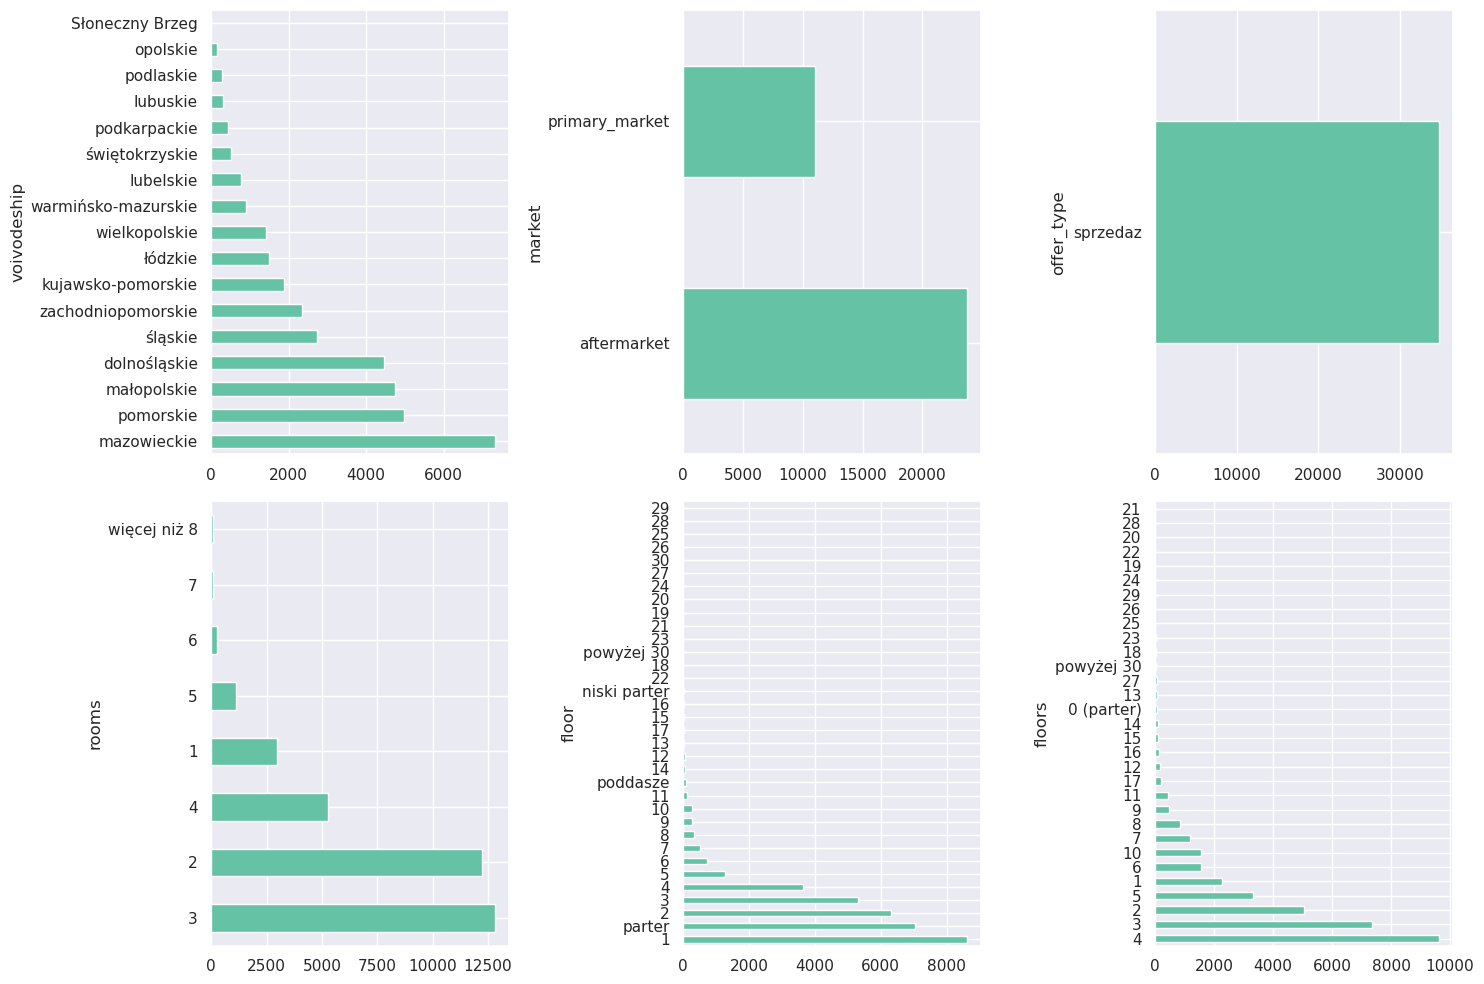

In [25]:
fig, axList = plt.subplots(nrows=2, ncols=3)
axList = axList.flatten()
fig.set_size_inches(15,10)

catagorical_columns = [x for x in frame.columns if frame[x].dtype == 'object' and x not in ['city','district','url']]

for ax, column in zip(axList, catagorical_columns):
    frame[column].value_counts().plot(kind='barh', ax=ax, ylabel=column)
    
plt.tight_layout()

In [26]:
frame.rooms.replace('więcej niż 8', '8', inplace=True)
frame.rooms = frame.rooms.astype('int')

In [27]:
frame.floor.replace(['niski parter','parter'], '0', inplace=True)
frame.floor.replace('powyżej 30', '30', inplace=True)
frame.drop(frame[frame.floor=='poddasze'].index, axis=0, inplace=True)
frame.floor = frame.floor.astype('int')

In [28]:
frame.floors.replace(['0 (parter)','powyżej 30'], ['0','30'], inplace=True)
frame.floors = frame.floors.astype('int')

In [29]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34685 entries, 1 to 73029
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            34685 non-null  object 
 1   district        29388 non-null  object 
 2   voivodeship     34685 non-null  object 
 3   localization_y  34685 non-null  float64
 4   localization_x  34685 non-null  float64
 5   market          34685 non-null  object 
 6   offer_type      34685 non-null  object 
 7   area            34685 non-null  float64
 8   rooms           34685 non-null  int64  
 9   floor           34685 non-null  int64  
 10  floors          34685 non-null  int64  
 11  build_yr        34685 non-null  float64
 12  price           34685 non-null  float64
 13  url             34685 non-null  object 
dtypes: float64(5), int64(3), object(6)
memory usage: 4.0+ MB


## adding custom column

In [30]:
frame['price_of_sqm'] = frame.price / frame.area

## dealing with outliers

In [31]:
# checking quantile values

outliers_dict = dict()

for column in ['area','build_yr','price','price_of_sqm']:
    upper_quartile = np.nanpercentile(frame[column], 99.0)
    lower_quartile = np.nanpercentile(frame[column], 1.0)
#     iqr = upper_quartile - lower_quartile
#     outliers_dict[column] = (lower_quartile-1.5*iqr, upper_quartile+1.5*iqr)
    outliers_dict[column] = (lower_quartile, upper_quartile)

outliers_dict

{'area': (23.6, 170.37959999999885),
 'build_yr': (1900.0, 2025.0),
 'price': (168000.0, 3352625.59999999),
 'price_of_sqm': (3193.204515986212, 31721.845238095164)}

In [32]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,34685.0,62.623987,30.542632,11.280000,44.100000,56.6,72.200000,4.600000e+02
build_yr,34685.0,1996.767825,36.788374,1200.000000,1978.000000,2014.0,2023.000000,3.000000e+03
price,34685.0,763223.087675,640798.064104,76900.000000,435000.000000,629000.0,874000.000000,1.600000e+07
price_of_sqm,34685.0,12295.519677,6069.969827,536.666667,8047.808765,11200.0,15312.916112,1.698462e+05


In [33]:
outliers_dict['build_yr'] = (1900.0, 2024.0)

In [34]:
for key in outliers_dict.keys():
    frame.drop(frame[frame[key] < outliers_dict[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict[key][1]].index, inplace = True)

In [35]:
frame[['area','build_yr','price','price_of_sqm']].describe().T

,count,mean,std,min,25%,50%,75%,max
area,31361.0,61.247137,23.931174,23.600000,44.950000,56.730000,71.92000,170.00
build_yr,31361.0,1997.655304,32.223430,1900.000000,1979.000000,2013.000000,2023.00000,2024.00
price,31361.0,722361.285418,424122.163869,168000.000000,444160.000000,632700.000000,867000.00000,3350000.00
price_of_sqm,31361.0,12062.743278,5251.672260,3194.174757,8060.606061,11139.534884,15150.01105,31718.75


In [36]:
len(frame[frame.floor>15]), len(frame[frame.floors>15])

(96, 511)

In [37]:
frame.drop(frame[frame.floor>15].index, axis=0, inplace=True)
frame.drop(frame[frame.floors>15].index, axis=0, inplace=True)

In [38]:
len(frame[frame.rooms>6])

58

In [39]:
frame.drop(frame[frame.rooms>6].index, axis=0, inplace=True)

## dealing with outliers in localization

In [40]:
frame.localization_x.min(), frame.localization_x.max()

(-0.82794, 23.93689128)

In [41]:
frame.localization_y.min(), frame.localization_y.max()

(-0.00133, 54.83313)

In [42]:
outliers_dict_2 = dict()
outliers_dict_2['localization_x'] = (14,25)
outliers_dict_2['localization_y'] = (48,55)

In [43]:
for key in outliers_dict_2.keys():
    frame.drop(frame[frame[key] < outliers_dict_2[key][0]].index, inplace = True)
    frame.drop(frame[frame[key] > outliers_dict_2[key][1]].index, inplace = True)

In [44]:
len(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)])

21

In [45]:
frame.drop(frame[(frame.localization_x%1==0) | (frame.localization_y%1==0)].index,inplace=True)

## checking histograms

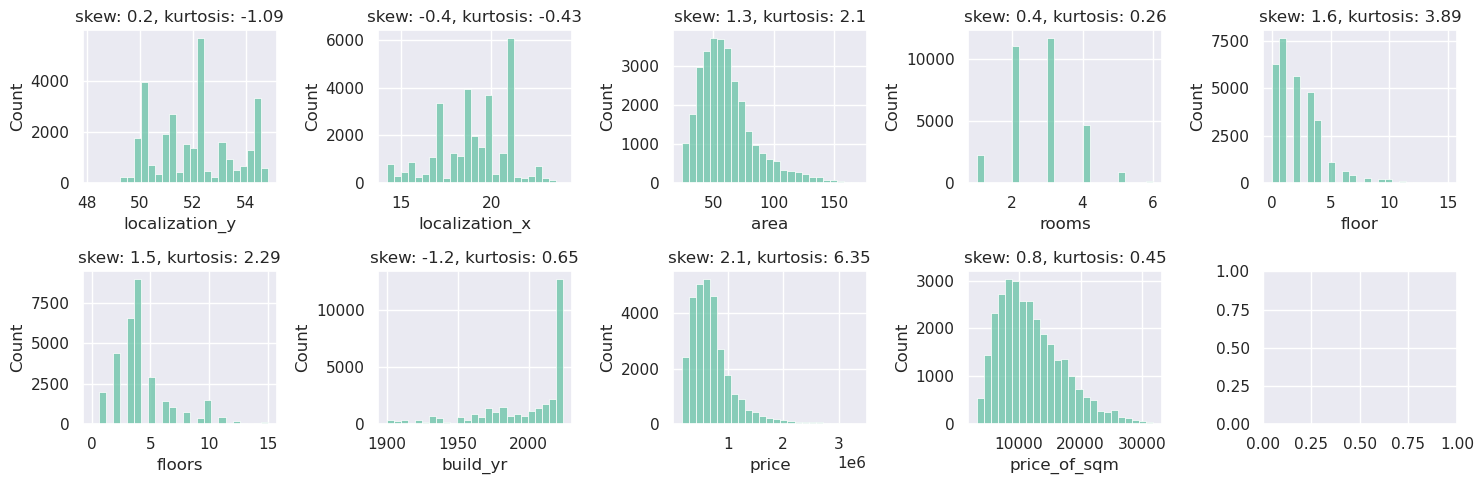

In [46]:
fig, axList = plt.subplots(nrows=2, ncols=5)
axList = axList.flatten()
fig.set_size_inches(15,5)

numeric_columns = [x for x in frame.columns if frame[x].dtype in ['float64','int64']]
kurtosis_dict = dict(frame[numeric_columns].kurtosis())

for ax, column in zip(axList, numeric_columns):
    sns.histplot(frame, x=frame[column], ax=ax, bins=25)
    ax.title.set_text(f'skew: {round(frame[column].skew(), 1)}, kurtosis: {round(kurtosis_dict[column], 2)}')
    
plt.tight_layout()

## data summary

In [47]:
round(frame.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
localization_y,30766.0,52.04,1.49,48.17,50.89,52.17,53.15,54.83
localization_x,30766.0,19.04,1.95,14.22,17.62,19.08,20.88,23.94
area,30766.0,61.13,23.77,23.60,44.86,56.70,71.70,170.00
rooms,30766.0,2.72,0.95,1.00,2.00,3.00,3.00,6.00
floor,30766.0,2.19,2.08,0.00,1.00,2.00,3.00,15.00
floors,30766.0,4.27,2.49,0.00,3.00,4.00,5.00,15.00
build_yr,30766.0,1997.39,32.32,1900.00,1978.00,2013.00,2023.00,2024.00
price,30766.0,715846.74,419752.65,168000.00,440000.00,629000.00,855600.00,3350000.00
price_of_sqm,30766.0,11978.93,5215.70,3194.17,8000.28,11025.69,15000.00,31718.75


In [48]:
frame.describe(include=['object']).T

,count,unique,top,freq
city,30766,1060,Warszawa,5041
district,26046,1019,Śródmieście,1551
voivodeship,30766,16,mazowieckie,6526
market,30766,2,aftermarket,21635
offer_type,30766,1,sprzedaz,30766
url,30766,30766,https://gratka.pl/nieruchomosci/nowe-mieszkanie-lodz-gorna-ul-wroblewskiego/ob/32670067,1


In [49]:
frame.reset_index(drop=True, inplace=True)

In [50]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30766 entries, 0 to 30765
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city            30766 non-null  object 
 1   district        26046 non-null  object 
 2   voivodeship     30766 non-null  object 
 3   localization_y  30766 non-null  float64
 4   localization_x  30766 non-null  float64
 5   market          30766 non-null  object 
 6   offer_type      30766 non-null  object 
 7   area            30766 non-null  float64
 8   rooms           30766 non-null  int64  
 9   floor           30766 non-null  int64  
 10  floors          30766 non-null  int64  
 11  build_yr        30766 non-null  float64
 12  price           30766 non-null  float64
 13  url             30766 non-null  object 
 14  price_of_sqm    30766 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 3.5+ MB


## saving the frame

In [51]:
# outfile = open('apartment_data_frame','wb')
# pkl.dump(frame, outfile)
# outfile.close()